# Infer the number of introductions of SARS-CoV2 into Wisconsin

March 30, 2020

As a favor for Kat, I am writing this notebook to enumerate the number of introductions of SARS-CoV2 into Wisconsin. Using the nextstrain json available [here](https://nextstrain.org/ncov), I am pulling the most recent json, reading it in as a tree object in baltic, and then parsing through the tree. Because we are currently only reconstructing geographic ancestral states at the country level (which makes sense), we do not have actual internal node identities for division. Therefore, I am implementing something more basic, as follows: 

1. For each Wisconsin tip in the tree, trace backwards (towards the root). Find the most interior internal node for which all of the children are from Wisconsin. Return that internal node. 

2. For each returned internal node, use baltic's subtree function to enumerate the entire subtree that descends from that node. Plot it. 

### Some caveats:
Because the tree is so unevenly and sparsely sampled, this should not be interpreted as a definitive or even statsically rigorous estimation of the number of introductions into Wisconsin. In this analysis, for 2 tips to be classified into the same cluster, they must share a common ancestor with each other before they share a common ancestor with a virus sampled from another geographic location. This means that instances in which 2 Wisconsin samples share a common ancestor at the same time that they also share an ancestor with a virus from New York will not be classified as a cluster. Conversely, 2 sequences that are currently quite closely related and cluster together could be broken apart if more sampling occurred, resulting in a cluster from a different geographic location nesting in between them. For these reasons, these inferences will change as the tree fills out. Additionally, to do this properly, a true discrete trait ancestral state reconstruction with reasonably similarly sampled demes would need to be employed. 

Another caveat is that this analysis does not attempt any inference about how divergent these clusters are from each other or how dissimilar sequences clustered together are. For example, if we are currently clustering 2 sequences together that are identical, it is much more likely that they are truly related and part of the same transmission chain than if they are 3 mutations different from each other. This could be sort of looked at by plotting divergence on the x-axis instead of time. 


### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

import copy
from scipy.special import binom
import datetime as dt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from IPython.display import HTML


try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio

## Functions for parsing tree and enumerating Wisconsin-only clusters

In [2]:
def return_dictionary_of_leaves(input_tree):
    leaves_dict = {}
    for k in input_tree.Objects:
        if k.branchType == "leaf":
            leaves_dict[k.name] = k
    return(leaves_dict)

In [3]:
"""given a tree, traverse the tree and pull out clusters containing only Wisconsin sequences. For each Wisconsin
tip in the tree, find its parent node. Enumerate is furthest back parent node that contains only Wisconsin
child tips. Return that parent node, plus all its childrne, and write to dictionary"""

def return_WI_only_clusters(tree, analysis_level, division_to_query, leaves_dict):
    Wisconsin_clusters = {}
    
    for k in tree.Objects:
        
        # if we come upon a leaf with the trait we are looking for, pass to node_to_return
        if k.branchType == "leaf" and analysis_level in k.traits and k.traits[analysis_level] == division_to_query:
            node_to_return = return_WI_only_nodes(k, analysis_level, division_to_query, leaves_dict)
            
            if node_to_return.branchType == "node":
                Wisconsin_clusters[node_to_return] = list(node_to_return.leaves)
            else:
                Wisconsin_clusters[node_to_return] = node_to_return.name
                
    return(Wisconsin_clusters)

In [4]:
"""This is a small, recursive function to return the most internal node whose children are all from Wisconsin. 
Given a node, go up one to its parent. Enumerate that parents children and its childrens division. If all child 
tips are from Wisconsin, then we are currently in a monophyletic Wisconsin clade. Go up again and repeat. Continue
iterating up the tree (towards the root) until we encounter a node whose child tips have a mix of divisions. 
Return the furthest up possible node that contains only Wisconsin child tips. """

def return_WI_only_nodes(input_node, analysis_level, division_to_query, leaves_dict):
    
    # for a given internal node, generate a list of all its children, i.e., tips descending from that node
    node = input_node.parent
    children = list(node.children)   # .children will output all of the direct descendants as baltic objects
    leaves = list(node.leaves)       # .leaves will output the names of all tips descending from the node
    
    # for each child tip, pull out its division
    local_node_divisions = []
    for l in leaves:
        leaf_object = leaves_dict[l]
        if analysis_level in leaf_object.traits:
            child_division = leaf_object.traits[analysis_level]
        else:
            child_division = "unknown"
        local_node_divisions.append(child_division)
    
    
    # if only Wisconsin tips are children, then we are in a monophyletic clade. move up 1 node and repeat 
    if set(local_node_divisions) == {division_to_query}:
        node_to_return = return_WI_only_nodes(node, analysis_level, division_to_query, leaves_dict)
        
    else: 
        node_to_return = input_node
        
    return(node_to_return)

In [5]:
"""using baltic's subtree function, enumerate the subtree descending from the supplied node"""

def return_subtree(node, tree):
    subtree=tree.subtree(node) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
    if subtree != None:
        subtree.traverse_tree()
        subtree.sortBranches()
        return(subtree)

In [51]:
"""enumerate geographic transitions for traits inferred with DTA, which is now country level"""

def retrieve_subtrees(tree):
    
    traitName='country'

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={country:[] for country in countries_list}
    subtype_trees={country:[] for country in countries_list}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName].lower().replace(" ","_")   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            kploc='ancestor'

        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_")==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if kloc in subtype_trees:
                    subtype_trees[kloc].append((kploc,subtree))
                else:
                    pass
                    #print(kloc, " not in countries list")
                    
    return(subtype_trees)

## Grab the most recent json file from nextstrain, and read it in as a baltic tree object 

The current `json_translation` defined here will translate auspice v2 jsons attributes into the proper tree attributes. This will not work for auspice v1 jsons. All ncov jsons are in v2. 

In [39]:
# define what you want to run this on (can use division, country, region, etc..., anything that is a trait in nextstrain)
# define which division or country you want to look at 
analysis_level = 'country'
division_to_query = 'Iceland'

In [54]:
# pull out all unique divisions or countries
divisions_keys = meta["colorings"][4]
countries_keys = meta["colorings"][5]

countries_list = []
colors = {}

for i in range(len(countries_keys["scale"])):
    country = countries_keys["scale"][i][0].lower().replace(" ","_")
    countries_list.append(country)
    colors[country] = countries_keys["scale"][i][1]

In [49]:
json_url='http://data.nextstrain.org/ncov_europe.json'
tree_json=json.load(csio(requests.get(json_url).content))

tree_object=tree_json['tree']
meta=tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

tree=bt.loadJSON(tree_object,json_translation,json_meta)


Tree height: 0.368322
Tree length: 135.812518
multitype tree
annotations present

Numbers of objects in tree: 7549 (3477 nodes and 4072 leaves)



In [50]:
subtype_trees = retrieve_subtrees(tree)

asia  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
oceania  not in countries list
north_america  not in countries list
north_america  not in countries list
north_america  not in countries list
north_america  not in countries list
oceania  not in countries list
north_america  not in countries list
north_america  not in countries list
oceania  not in countries list
oceania  not in countries list
oceania  not in countries list
asia  not in countries list
oceania  not in countries list
oceania  not in countries list
oceania  not in countries list
north_america  not in countries list
north_america  not in countries list
asia  not in countries list
north_america  not in countries list
north_america  not in countries list
north_america  not in countries list
oceania  not in countries list
north_america  not in countries list
north_america  not in cou

oceania  not in countries list
oceania  not in countries list
oceania  not in countries list
africa  not in countries list
africa  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
asia  not in countries list
africa  not in countries list
africa  not in countries list
north_america  not in countries list
asia  not in countries list
north_america  not in countries list
africa  not in countries list
asia  not in countries list
africa  not in countries list
africa  not in countries list
africa  not in countries list
north_america  not in countries list
oceania  not in countries list
africa  not in countries list
oceania  not in countries list
africa  not in countries list
oceania  not in countries list
oceania  not in countries list
south_america  not in countries list
south_america  not in countries list
oceania  not in countries list
asia  not in countries list
africa  not in countries list
asia  not in countries list
north_america

In [53]:
print(subtype_trees["iceland"])

[('italy', <baltic.tree object at 0x12465b940>), ('italy', <baltic.tree object at 0x1237d1908>), ('italy', <baltic.tree object at 0x126184dd8>), ('italy', <baltic.tree object at 0x128656438>), ('italy', <baltic.tree object at 0x127228550>), ('spain', <baltic.tree object at 0x127153d30>), ('italy', <baltic.tree object at 0x127741470>), ('italy', <baltic.tree object at 0x1286c3a90>), ('italy', <baltic.tree object at 0x1252b49b0>), ('italy', <baltic.tree object at 0x1266597f0>), ('italy', <baltic.tree object at 0x1285d22b0>), ('austria', <baltic.tree object at 0x11e7fa278>), ('italy', <baltic.tree object at 0x129912c50>), ('italy', <baltic.tree object at 0x12975fa20>), ('austria', <baltic.tree object at 0x129186908>), ('austria', <baltic.tree object at 0x1273eb5f8>), ('austria', <baltic.tree object at 0x1237260f0>), ('austria', <baltic.tree object at 0x128e1f588>), ('austria', <baltic.tree object at 0x1284e4518>), ('austria', <baltic.tree object at 0x127910b00>), ('denmark', <baltic.tree 

(-5, 1016)

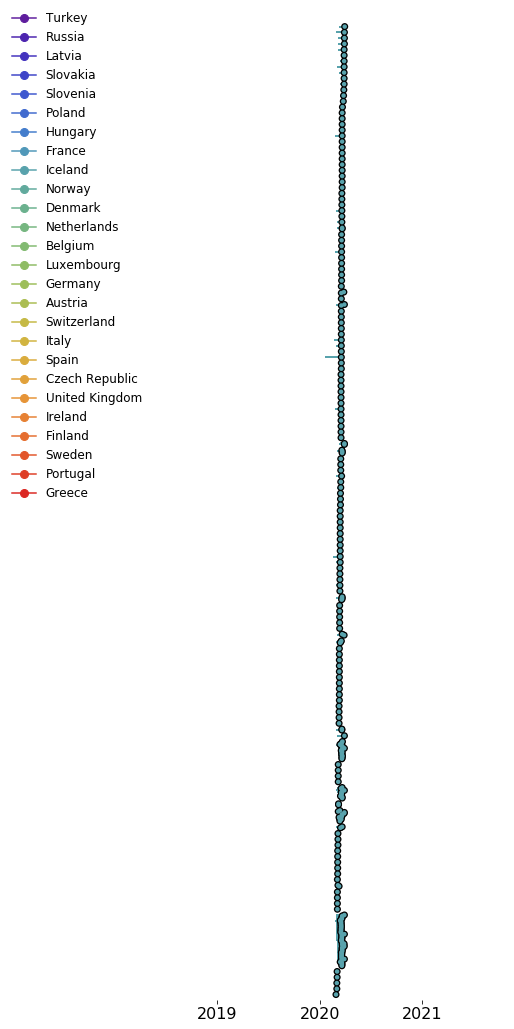

In [59]:
fig,ax1 = plt.subplots(1, figsize=(6,18),facecolor='w')

axes = [ax1]

traitName='country'
tipSize=20
mpl.rcParams['font.size']=16
cumulative_y=0

# # this sets the vertical dashed lines on the tree
#dates = [2016.25,2016.5,2016.75,2017,2017.25,2017.5]   
#[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

branchWidth=1.75 ## default branch width

x_attr=lambda k: k.absoluteTime
c_func=lambda k: colors[k.traits[traitName].lower().replace(" ","_")]
s_func=lambda k: tipSize
z_func=lambda k: 100

su_func=lambda k: tipSize+30
cu_func=lambda k: 'k'
zu_func=lambda k: 99

for subtree in subtype_trees['iceland']: ## iterate over trait values
    origin = subtree[0]
    loc_tree = subtree[1]
        
    y_attr=lambda k: k.y+cumulative_y
        
    loc_tree.plotTree(ax1,x_attr=x_attr,y_attr=y_attr,colour_function=c_func)
    loc_tree.plotPoints(ax1,x_attr=x_attr,y_attr=y_attr,size_function=s_func,
                            colour_function=c_func,zorder_function=z_func)
    loc_tree.plotPoints(ax1,x_attr=x_attr,y_attr=y_attr,size_function=su_func,
                            colour_function=cu_func,zorder_function=zu_func)
        
#     oriC = colors[origin.lower().replace(" ","_")]
#     if loc_tree.root.absoluteTime==None:
#         oriX=loc_tree.root.absoluteTime
#         oriY=loc_tree.root.y+cumulative_y
#     else:
#         oriX=loc_tree.root.parent.absoluteTime
#         oriY=loc_tree.root.y+cumulative_y
#     ax1.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
    cumulative_y+=loc_tree.ySpan+5 ## increment y displacement
        
# add in a legend
han_list = []
for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

ax1.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[-0.5, 0.5], loc=3, prop={'size': 12}, facecolor='w')
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()

[ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax1.tick_params(axis='y',size=0)
ax1.set_yticklabels([])
ax1.set_ylim(-5,cumulative_y)
#ax1.set_xlim(2016.25,2017.76)

#ax1.set_xticks([2016.25,2016.5,2016.75,2017,2017.25,2017.5])
#ax1.set_xticklabels(['Apr\n2016','Jul\n2016','Oct\n2016','Jan\n2017','Apr\n2017','Jul\n2017'], fontsize=12)
#ax1.axes.get_xaxis().set_ticks([])

## Run functions to enumerate Wisconsin clusters and plot

In [11]:
leaf_dictionary = return_dictionary_of_leaves(tree)
Wisconsin_clusters = return_WI_only_clusters(tree, analysis_level, division_to_query, leaf_dictionary)

In [13]:
Wisconsin_clusters

128

In [10]:
# convert to subtrees for plotting
clusters = []

for w in Wisconsin_clusters: 
    subtree = return_subtree(w, tree)
    clusters.append(subtree)

In [11]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

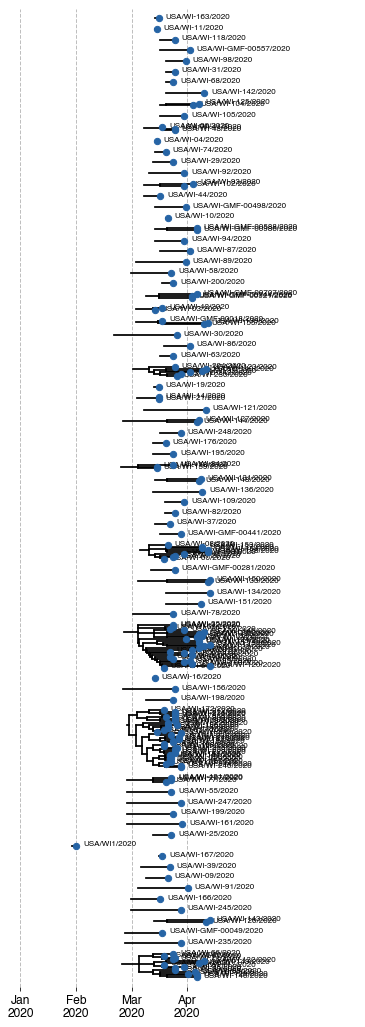

In [14]:
fig,ax1 = plt.subplots(1, figsize=(6,18),facecolor='w')

axes = [ax1]

traitName='division'
tipSize=40
mpl.rcParams['font.size']=16
cumulative_y=0

# # this sets the vertical dashed lines on the tree
dates = []  
for i in np.arange(2020.0,2020.3,0.083):
    dates.append(i)
[ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]

branchWidth=1.75 ## default branch width

x_attr=lambda k: k.absoluteTime
#c_func=lambda k: colors[k.traits[traitName].lower().replace(" ","_")]
s_func=lambda k: tipSize
z_func=lambda k: 100

su_func=lambda k: tipSize+30
cu_func=lambda k: 'k'
zu_func=lambda k: 99
text_func=lambda k: k.name

cumulative_y = 0

for subtree in clusters: ## iterate over trait values
        
    for k in subtree.Objects: ## iterate over objects in tree

        x=k.absoluteTime 
        y = k.y + cumulative_y

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        
        c="#2664A5"
        if k.branchType=='leaf': ## if leaf...
            
            label_text = k.name
            label_size=8
                
            ax1.scatter(x,y,s=tipSize,facecolor=c,edgecolor=c,zorder=11) ## plot circle for every tip
            ax1.text(x+0.01,y,s=label_text,size=label_size)
                
        elif k.branchType=='node':
            # this plots the vertical line
            ax1.plot([x,x],[k.children[-1].y+cumulative_y,k.children[0].y+cumulative_y],lw=branchWidth,color="black",ls='-',zorder=9,solid_capstyle='round')

        ax1.plot([xp,x],[y,y],lw=branchWidth,color="black",ls='-',zorder=9)
        
    # increment cumulative y displacement
    cumulative_y+=subtree.ySpan+5 

           
# ax1.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[-0.5, 0.5], loc=3, prop={'size': 18}, facecolor='w')
ax1.xaxis.tick_bottom()
ax1.yaxis.tick_left()

[ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

ax1.tick_params(axis='y',size=0)
ax1.set_yticklabels([])
ax1.set_ylim(-5,cumulative_y)
ax1.set_xlim(2020.0,2020.5)

ax1.set_xticks(dates)
ax1.set_xticklabels(['Jan\n2020','Feb\n2020','Mar\n2020','Apr\n2020'], fontsize=12)
plt.savefig("/Users/lmoncla/src/ncov-ipython-code/WI-introductions-2020-03-30.pdf")